# <p style="text-align: center;">MIS 382N: Advanced Machine Learning</p>
# <p style="text-align: center;">Homework 3</p>
## <p style="text-align: center;">Total points: 85</p>
## <p style="text-align: center;">Due: Monday, **Oct 18th** submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. Please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting (%matplotlib inline). 

**Note: Notebooks MUST have the images embedded in them. There will be no regrades if attached images do not render in the notebook. Please re download from canvas after submission and make sure all attached images render without errors. (Hint: Image module from IPython.display)**

**This can be an individual assignment or group of 2. If you choose to do it as a group, please specify who you are working with (name and EID), then only one student should submit the homework. Put your name and eid here.**

Name:Shubham Singh

EID:ss96589


# Question 1: Stochastic gradient descent II (20 pts)

Write an SGD solution in Python to the non-linear model without using any other library except for those provided in the code template below. 

$$ y = w_0 + w_1x_1 + w_2x_1x_2 + w_3x_1^2x_2 + w_4x_1x_2^2 + w_5x_2^3$$ 

The solution class template is given. The `init()` function of the class takes as input the `learning_rate`, `regularization_constant` and `number_of_epochs`. The `fit()` method must take as input `X`, `y` and `update_rule` which can be `'sgd_momentum'` or `'RMSprop'`. The `predict()` method takes an `X` value (optionally, an array of values). 

Use your new gradient descent regression to train your model and predict the data given in 'SGD_samples.csv', for 30 epochs, using learning rates: `[0.0001, 0.001, 0.01, 0.05]` and regularization (ridge regression) constants: `[0, 0.01, 0.1]`. **(8 points)** 

Plot MSE and the $w$ parameters as a function of epoch (for 30 epochs) for the best 2 combinations of `learning_rate` and `regularization_constant` for SGD-Momentum, RMSprop, i.e., for each combination, you should have one plot for MSE vs Epoch and another for the parameters(weights) vs Epoch using respectively SGD-Momentum and RMSprop, hence in total 8 plots. Report the `learning_rate`, `regularization_constant` and MSE at the end of 30 epochs for the two best combinations for SGD-Momentum and RMSprop respectively. **($4\times 2 = 8$ pts)**

Observe the results, compare the performance of the two learning methods **(4 pts)**. 

Here is a blog which you can go through to know about RMSprop and Adam - [blog](http://ruder.io/optimizing-gradient-descent/).

Following codes are for your reference, please don't change the initialization values of the given parameters.


# Answer

In [1]:
%matplotlib inline
import copy

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class LinearRegression:
    
  def __init__(self, learning_rate, regularization, n_epoch):
    self.learning_rate = learning_rate
    self.n_epoch = n_epoch
    self.regularization = regularization
    self.coef = np.zeros(6) # coefficient vector
    self.eps = 10**-8 # only used in adagrad
    self.cache = np.zeros(self.coef.shape) # only used in adagrad
    self.mu = 0.9 # used in momentum

    self.prev_grad_stat=0# first used in momentum, old cached update_vector
    self.ct=0

  def rmsprop(self, gradient):
    '''
    updates self.coef based on gradient using rmsprop
    '''
    den=pow((self.cache + self.eps),1/2)

    lr_vect=self.learning_rate/den

    update_vector=lr_vect*gradient

    self.coef -= update_vector



    
  def sgd_momentum(self, gradient):
    '''
    updates self.coef based on gradient using Sgd_momentum
    '''

    update_vector=(1-self.mu)*self.learning_rate*gradient + self.mu*self.prev_grad_stat
    #Current gradient + old direction stat , self.learning_rate has somewhat encompassed the values for 1-self.mu
    self.coef -= update_vector

    self.prev_grad_stat = update_vector #updating cache 
    self.ct+=1


    
  def fit(self, X, y, update_rule='sgd_momentum', verbosity=0,
          plot=False):
              
    '''
    Fit the model given X, y. It uses the specified update_rule
    and displays a plot of the coefficients vs epochs, and mse vs epochs if plot is set as True. 

    -> use get_features to get the features from X
    -> for epoch in epochs:
        iterate through all x, y.
            compute prediction using linearPredict.
            compute gradient.
            pass this gradient to the corresponding update function and update the coefficients
            keep track of mse and coefficients
    -> plot if required

    '''

    error=[]
    coef=[]

    temp_x=self.get_features(X)
    self.update_rule=update_rule

    for epoch in range(self.n_epoch):
      rws=temp_x.shape[0]

      for rw in range(rws):
        x_i=temp_x[rw,:]
        y_pred=self.linearPredict(x_i)

        residual=y[rw]-y_pred

        gradient= -1*(residual)*(x_i) + self.regularization*self.coef

         

        if update_rule=='sgd_momentum':
          self.sgd_momentum(gradient)

        elif update_rule=='rmsprop':
          self.cache = (1-self.mu)*pow(((residual)*(x_i)),2) + self.mu*self.cache #will update cache of gradient foe each coefficient that will help the learning rate to adapt

          self.rmsprop(gradient)

      temp_coef=copy.copy(self.coef)
      coef.append(temp_coef)

      epoch_residual=y-self.linearPredict(temp_x)
      error.append(np.mean(pow(epoch_residual,2)))

    if plot:
      f,ax=plt.subplots(1,2,figsize=(20,8))

      objects=ax[0].plot(coef)
      ax[0].legend(iter(objects),('w0','w1','w2','w3','w4','w5'))
      ax[0].set_title('weights_'+str(self.update_rule)+'_model_lr_'+str(self.learning_rate) +'_reg_'+str(self.regularization)+'_epch_'+str(self.n_epoch))

      ax[1].plot(error)
      ax[1].set_title('mse_'+str(self.update_rule)+'_model_lr_'+str(self.learning_rate) +'_reg_'+str(self.regularization)+'_epch_'+str(self.n_epoch))

    if verbosity==1:
      return (coef,error)
    


  def get_features(self, X):


    '''
    X (input) is the nx2 dimensional array - n data points with X_1 and X_2.
    It returns a nX5 dimensional array - n data points with 1, X_1, X_1X_2, X_1^2X_2^1, X_2^3.
    '''


    rws=X.shape[0]
    temp_x=np.ones(shape=(rws,6))

    temp_x[:,1]=X[:,0]
    temp_x[:,2]=X[:,0]*X[:,1]
    temp_x[:,3]=pow(X[:,0],2)*pow(X[:,1],1)
    temp_x[:,4]=pow(X[:,0],1)*pow(X[:,1],2)
    temp_x[:,5]=pow(X[:,1],3)

    return temp_x



        
  def linearPredict(self, X_features):
    '''
    returns the dot product of X and self.coef
    '''
    temp_y=X_features@self.coef
    return temp_y

In [2]:
# # Only use this code block if you are using Google Colab.
# # If you are using Jupyter Notebook, please ignore this code block. You can directly upload the file to your Jupyter Notebook file systems.
# from google.colab import files

# ## It will prompt you to select a local file. Click on “Choose Files” then select and upload the file. 
# ## Wait for the file to be 100% uploaded. You should see the name of the file once Colab has uploaded it.
# # uploaded = files.upload()

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

num_terms = 6

data = pd.read_csv('SGD_samples.csv')
X = np.array([data['x1'].values, data['x2'].values]).T
y = data['y'].values
n_epochs = 30
learning_rate = [0.0001, 0.001, 0.01, 0.05]
regularization = [0, 0.01, 0.1]

In [4]:
X.shape

def train_my_model(lr,reg,epchs,ur,X,y,plt=False):

  lr=LinearRegression(learning_rate=lr, regularization=reg, n_epoch=epchs)
  xx=lr.get_features(X)

  c,e=lr.fit(X,y,update_rule=ur,verbosity=1,plot=plt)
  final_error=e[-1]
  return final_error

### Training of model using sgd_momentum and rmsprop based methods

In [5]:
from itertools import product
lt_tbu=list(product(learning_rate,regularization))


u_r='sgd_momentum'

bst_1,bst_2=None,None
err_1,err_2=np.inf,np.inf#we will expect err_1 to be the lowest

for params in lt_tbu:
  temp_err=train_my_model(params[0],params[1],30,u_r,X,y)
  # print(temp_err)

  if temp_err <=err_1:
    err_1,err_2=temp_err,err_1
    bst_1,bst_2=params,bst_1
  elif temp_err< err_2:
    #only this happening
    err_2=temp_err
    bst_2=params

sgd_err_params={'sgd_bst_1': {'learning_rate':bst_1[0],
                              'regularization':bst_1[1],
                              'error':err_1},
                'sgd_bst_2': {'learning_rate':bst_2[0],
                              'regularization':bst_2[1],
                              'error':err_2}
                }




# train_my_model(0.001,0.01,30,X,y)
sgd_err_params


u_r='rmsprop'

bst_1,bst_2=None,None
err_1,err_2=np.inf,np.inf#we will expect err_1 to be the lowest

for params in lt_tbu:
  temp_err=train_my_model(params[0],params[1],30,u_r,X,y)
  # print(temp_err)

  if temp_err <=err_1:
    err_1,err_2=temp_err,err_1
    bst_1,bst_2=params,bst_1
  elif temp_err< err_2:
    #only this happening
    err_2=temp_err
    bst_2=params

rms_err_params={'rms_bst_1': {'learning_rate':bst_1[0],
                              'regularization':bst_1[1],
                              'error':err_1},
                'rms_bst_2': {'learning_rate':bst_2[0],
                              'regularization':bst_2[1],
                              'error':err_2}
                }


### Reporting of associated parameters and error for best two models followed by respective graphs

In [6]:
# print(rms_err_params,sgd_err_params,sep='\n')
print("{" + ",\n".join("{!r}: {!r}".format(k, v) for k, v in rms_err_params.items()) + "}",'\n\n')
print("{" + ",\n".join("{!r}: {!r}".format(k, v) for k, v in sgd_err_params.items()) + "}")


{'rms_bst_1': {'learning_rate': 0.001, 'regularization': 0, 'error': 0.020203078865835295},
'rms_bst_2': {'learning_rate': 0.001, 'regularization': 0.01, 'error': 0.020346851401293064}} 


{'sgd_bst_1': {'learning_rate': 0.01, 'regularization': 0, 'error': 0.020195535187159188},
'sgd_bst_2': {'learning_rate': 0.01, 'regularization': 0.01, 'error': 0.020329348110272268}}


0.020346851401293064

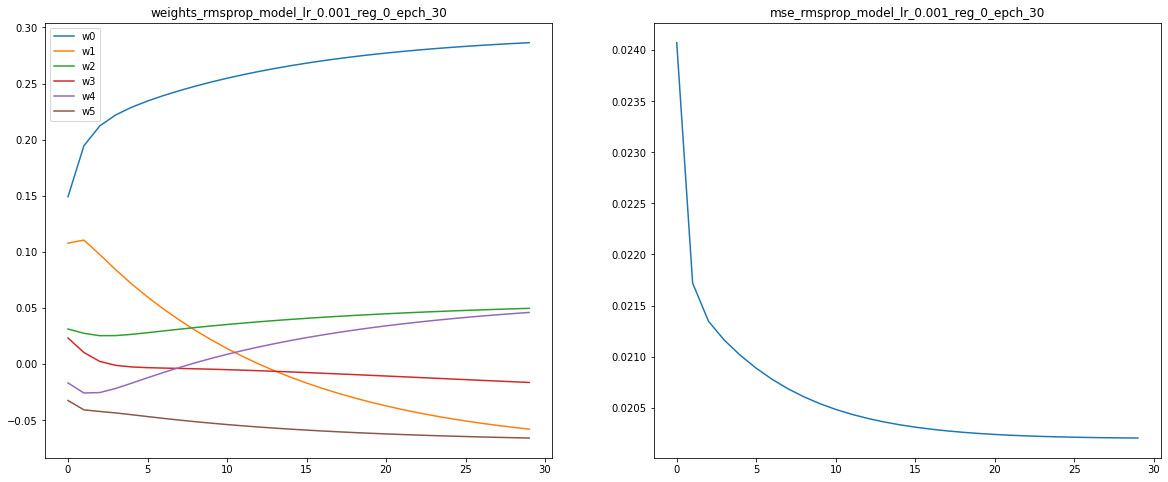

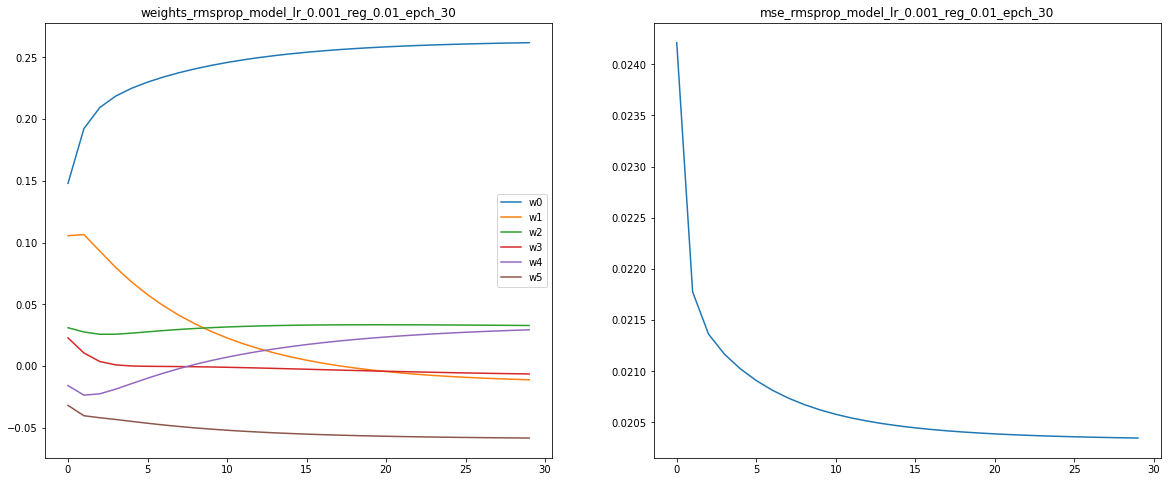

In [7]:
params_tbu=rms_err_params['rms_bst_1']
train_my_model(params_tbu['learning_rate'],params_tbu['regularization'],30,'rmsprop',X,y,plt=True)

params_tbu=rms_err_params['rms_bst_2']
train_my_model(params_tbu['learning_rate'],params_tbu['regularization'],30,'rmsprop',X,y,plt=True)

0.020329348110272268

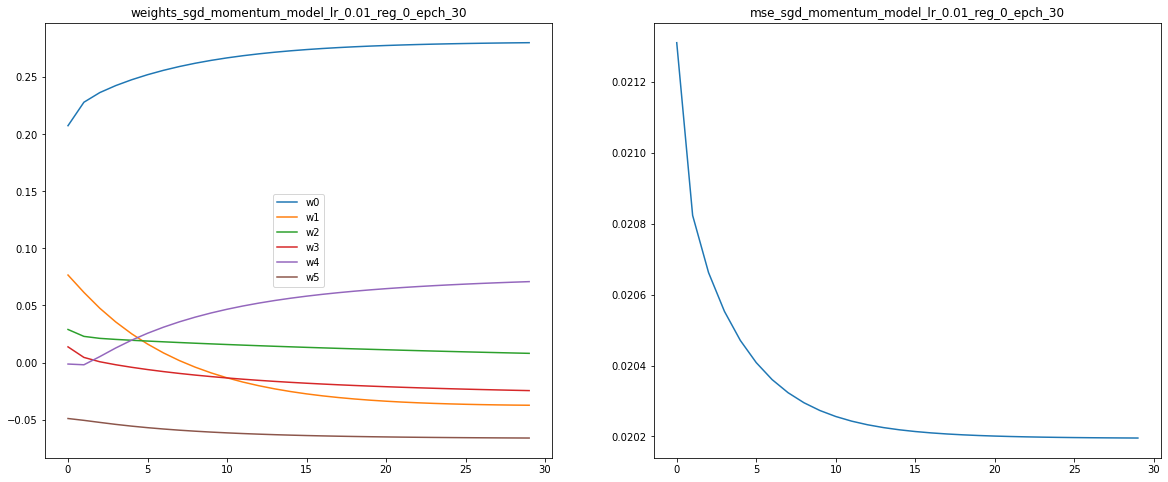

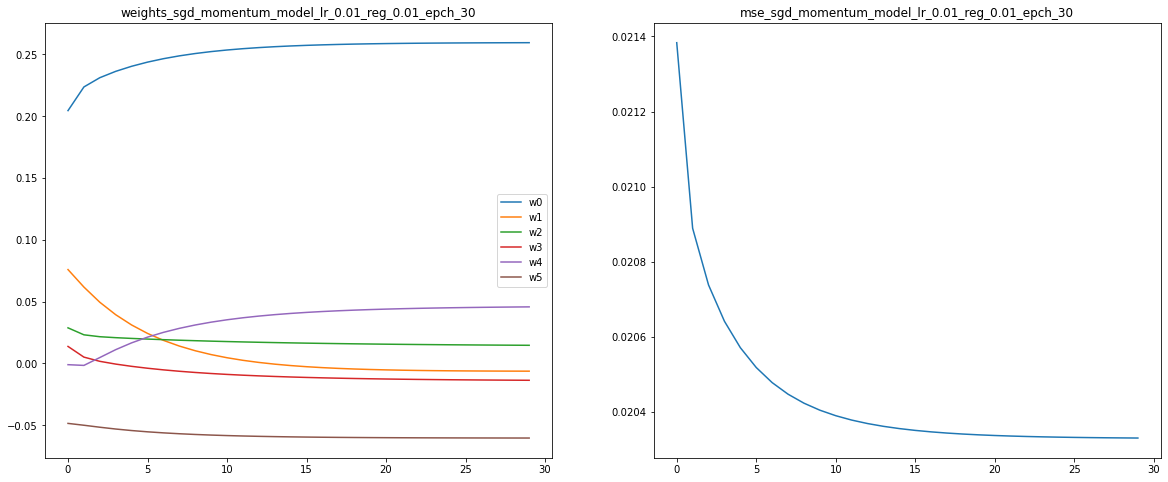

In [8]:
params_tbu=sgd_err_params['sgd_bst_1']
train_my_model(params_tbu['learning_rate'],params_tbu['regularization'],30,'sgd_momentum',X,y,plt=True)

params_tbu=sgd_err_params['sgd_bst_2']
train_my_model(params_tbu['learning_rate'],params_tbu['regularization'],30,'sgd_momentum',X,y,plt=True)

### Comparitive analysis:

The updates for respective weights in rmsprop method is slightly different from that of models trained on momentum-method.

There is a sense on localised increment in the w1, when the model is trained using different learning rates for different attributes.

The update vector/flow of w2, the green curve, is diffrenet in case of rms and momentum based training.
Possibly when trained individualy using a specific learning rate, weight curve was able to generalize its true nature and attain different minima.

The error decreases at a faster rate, in initial epochs, when we use single learning rate for all the features.
The slow rate of decrement of error in sgd can be attributed to high inconsistency between learning vectors, accentuated with different learning rates,in intial phase/epochs of training





# Question 2: Tensorflow Playground (15 pts)

In this question, you will be playing with [Tensorflow Playground](https://playground.tensorflow.org).

Select "**Classification**" as the **Problem Type**. Among the four datasets shown in DATA, please select the **top right** dataset. 

Use the following settings as the DEFAULT settings for all **subquestions**: Learning rate = 0.03, Activation = Tanh, Regularization = None, Ratio of training to test data = 50%, Noise = 0, Batch Size = 30, input as $X_1$ with $X_2$, One hidden layer with two neurons.

a) **(4 pts)** Use the DEFAULT setting and run two experiments - one using **Tanh** as the activation function and one using the **Linear** activation function. Report the train, test losses for both at the end of **1000 epochs**. What qualitative difference do you observe in the decision boundaries obtained? What do you think is the reason for this? 

We will now study the effect of certain variations in the network structure or training process, keeping all other aspects the same as in the DEFAULT setting specified above, with **Tanh** as the activation.

b) **(4 pts)** Effect of number of hidden units: Keep other settings the same as in DEFAULT, report the training loss and test loss at the end of 1000 epochs **using 4 neurons and 8 neurons in the hidden layer**. What do you observe in terms of the decision boundary obtained as the number of neurons increases? What do you think is the reason for this? 

c) **(4 pts)** Effect of Learning rate and number of epochs: Keep other settings the same as in DEFAULT, change the Activation to **ReLU** and use **4 neurons** in the hidden layer. For learning rate 10, 1, 0.1, 0.01 and 0.001, report the train, test losses at the end of **100 epochs**, **1000 epochs** respectively. What do you observe from the change of loss vs learning rate, and the change of loss vs epoch numbers? 

d) **(3 pts)** Use the DEFAULT setting. Play around with any hyperparameters, network architectures or input features (such as $\sin(X_1), X_1^2$ etc.), and report the best train and test loss you obtain (test loss should be no greater than 0.06). Attach the screenshot showing your full network, output and the parameters. Briefly justify your results, and comment on what helps/what doesn't help with lowering the loss, etc. 

# Answer:

a) In the above example, we are using "Classification" as our problem type.
The training and test loss for the Linear function for the first dataset is 0.495 and 0.511 respectively whereas the training and test loss for the Tanh function is 0.230 and 0.328 respecctively. For the different datasets, we get more demarcated and distinct decision boundaries for the Tanh activation function as compared to the Linear function. This is because, the linear activation function cannot perform well on a classifcation problem because the gradient value becomes a constant quantity. Such an activation function adds no non-linearity; hence the whole network would just be equivalent to a single linear neuron. Whereas, tanh performs the job better by bringing non-linearity into the picture. Since tanh centers the data by bringing the mean close to 0, it becomes easier for the subsequent layers to learn and hence it performs better as evident from the loss values.

b) With 4 neurons in the hidden layer, the training and test loss is 0.014 and 0.023 respectively for the second dataset. Whereas with 8 neurons in the hidden layer, the training and test loss is 0.010 and 0.022 respectively for the second dataset. Similar are the results for the first dataset as well. We observe a reduction in both the training and test losses upon increasing from 4 to 8; but in the decision boundary we find that it starts to overfit the training data upon increasing the number of hidden units. This is because the model becomes more complex and variance increases with the increase in hidden units.
Increasing the hidden layer neurons helps to better estimate the complexity of the problem, here many combinations of input features can be formulated and employed in order to learn and classify the output data. It is evident from the 8 types of separators that can be visualised on the hidden layer nodes, each one is computed using combination of input features.This process may increase the training time for the entire model. However, if the objective function is too much complicated for learning, increasing hidden layer neurons is a good thing as it may provide us with more number of secondary features to choose from. In order to avoid overdetermining of the problem, one can train the model for a fewer number of epochs or can perform an parallel observational study of train and test loss. 

c) For the first dataset, for 100 epochs:-
for learning rate 10, the train and test loss are 0.584 and 0.765 resp. For learning rate 1, the train and test loss are 0.001 and 0.006 resp. For learning rate 0.1, the train and test loss are 0.007 and 0.016 resp. For learning rate 0.01, the train and test loss are 0.166 and 0.155 resp. For learning rate 0.001, the train and test loss are 0.389 and 0.401 resp.
For 1000 epochs:- 
for learning rate 10, the train and test loss are 0.904 and 1.096 resp. For learning rate 1, the train and test loss rate are 0.000 and 0.002 resp. For learning rate 0.1, the train and test loss are 0.002 and 0.012 resp. For learning rate 0.01, the train and test loss are 0.014 and 0.016 resp. For learning rate 0.001, the train and test loss are 0.115 and 0.116 resp.
We therefore find that keeping a learning rate very high as 10 results in high training and test loss because the gradient descent function fails to converge to a minimum value. The ideal learning rate seems to be 1. With further decrease of learning rate, the losses increase progressively with the number of epochs fixed which indicates that the gradient function approaches the minimum value very slowly.
With change in number of epochs, we observe that for learning rate of 10, the losses have incresed which indicates that the gradient function failed to converge to a minimum and has instead shooted up with epochs. But for the other learning rates, we observe a decrease in losses indicating that the graident descent fucntion is slowly approaching the minimum value with the increase in epochs.


d)
Increasing number of input features, that too non linear features that are square based and sinusoidal in type, helps the model train better.
Even with less number of hidden layers, the model was able to create non linear separators for the training  dataset, that even performed well on the testing dataset.
This can be attributed to inclusion of non linear separator especially x1*x2 that helped the model learn about the dataset precisely.(fig 1)

Appropriate knowlege about the dataset and its associative behaviour with different features, can help one train a model easily without even employing complicated models. In this case x1*x2 can all by itself help the model train very well.(fig 2)

However, same degree of learning can be achieved if we use only two basic x1 and x2 based features and increase the number of neurons in the hidden layers, lets say 8.If we let model train for some epochs, the model will formulate its own sets of non linear separators that will help classify the data well.
(fig 3)

This can be further improved by adding neurons to the output layer, or by using appropriate activation fuunction for the output layer.
(fig 4)

![Fig_1](all_features.jpg)


![Fig_2](1_apt_feature.jpg)

![Fig_3](2_features_2_out.jpg)

![Fig_4](2_features_1_out.jpg)

In [9]:
# install pyod using pip first
# !pip install pyod

# Question 3: Outlier detection using PyOD (30 pts)

Oulier detection, or anomaly detection is usually an unsupervised learning task where the objective is to identify suspicious observations in data. It has been widely used in military surveillance for enemy activities to prevent attacks, intrusion detection in cyber security, fraud detection for credit cards, etc.

PyOD is a comprehensive and scalable Python library for detecting outlying objects in multivariate data. PyOD includes more than 30 detection algorithms and provides unified APIs which makes it quite handy to use. In this question, you will play with PyOD, explore three different outlier detection algorithms and compare their performances. First let's install PyOD.

```
# install pyod using pip first
!pip install pyod
```

You can load the data stored in 'Q3_train_dataset.csv' and 'Q3_test_dataset.csv' using the following codes.

```
import pandas as pd
# Load data code goes here
train_df = pd.read_csv('Q3_train_dataset.csv')
test_df = pd.read_csv('Q3_test_dataset.csv')

X_train = train_df[['X_train_0', 'X_train_1', 'X_train_2', 'X_train_3', 'X_train_4']].to_numpy()
y_train = train_df[['y_train']].to_numpy()
X_test = test_df[['X_test_0', 'X_test_1', 'X_test_2', 'X_test_3', 'X_test_4']].to_numpy()
y_test = test_df[['y_test']].to_numpy()
```

 `X_train` and `X_test` contain the features, with the dimension of 5. `y_train` and `y_test` store the outlier labels, 0 means normal data, 1 means outlier data. 
 
a) **(5 pts)** **Fit `X_train` to a linear outlier detection model Minimum Covariance Determinant (MCD) using PyOD**, this [page](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.mcd) will provide some functions you may need. 

```
from pyod.models.mcd import MCD
clf = MCD() # initialize MCD class using the default parameters

# YOUR CODE SHOULD COME HERE, FIT THE MODEL USING X_TRAIN
```
**Use the fitted model to predict the outlier labels of `X_test`. Compute the raw outlier scores on `X_test` using `decision_function()`.**

**Run PyOD's `evaluate_print()` function using the test set ground truth outlier labels and the raw outlier scores predicted by the model, to compute the ROC and Precision@n results .** 

```
from pyod.utils.data import evaluate_print
```

b) **(5 pts)** `X_train` and `X_test` are 5-dimension features, which makes it impossible to visualize them in Euclidean plane. But we can use Principal Component Analysis (PCA) to reduce the dimensions of `X_train` and `X_test` to 2, and then plot them. You may want to use `fit_and_transform()` function.


```
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Fit pca to X_train and X_test and transform 
train_principalComponents = # IMPLEMENT
test_principalComponents = # IMPLEMENT
```

After reducing the dimension to 2, now you can visualize the outliers using PyOD's `visualize()` function. Please plot the visualization. You may find [this](https://pyod.readthedocs.io/en/latest/pyod.utils.html#module-pyod.utils.example) useful on how to use `visualize()` .

```
from pyod.utils.example import visualize
```

Now you should be able to observe the ground truth outliers and the outliers predicted by the model.


c) **(20 pts)** Apply the same process as in (a) and (b) to the following two models, and visualize the outlier results. Please compare the performance of the three models in terms of their ROC, Precision@n, and what you observe from the three visualizations.

*   [Proximity-Based model - Clustering Based Local Outlier Factor (CBLOF)](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof)
*   [Probabilistic model - Copula-based Outlier Detection (COPOD)](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.copod)

```
from pyod.models.cblof import CBLOF
from pyod.models.copod import COPOD
```

# Answer:

In [10]:
# install pyod using pip first
!pip install pyod

In [11]:
import pandas as pd
# Load data code goes here
train_df = pd.read_csv('Q3_train_dataset.csv')
test_df = pd.read_csv('Q3_test_dataset.csv')

X_train = train_df[['X_train_0', 'X_train_1', 'X_train_2', 'X_train_3', 'X_train_4']].to_numpy()
y_train = train_df[['y_train']].to_numpy()
X_test = test_df[['X_test_0', 'X_test_1', 'X_test_2', 'X_test_3', 'X_test_4']].to_numpy()
y_test = test_df[['y_test']].to_numpy()

In [12]:
# (a)
from pyod.models.mcd import MCD
clf = MCD() # initialize MCD class using the default parameters

# fit the model using X_train
clf.fit(X_train)

# YOUR CODE SHOULD COME HERE

MCD(assume_centered=False, contamination=0.1, random_state=None,
  store_precision=True, support_fraction=None)

In [13]:
from pyod.utils.data import evaluate_print
# predict the outlier labels of X_test using the trained model, compute the raw outlier scores on X_test using decision_function()
# then use evaluate_print() to print out the evaluation results


y_pred=clf.predict(X_test)
y_score=clf.decision_function(X_test)

evaluate_print(clf,y_test,y_score)
# YOUR CODE SHOULD COME HERE

MCD(assume_centered=False, contamination=0.1, random_state=None,
  store_precision=True, support_fraction=None) ROC:0.8689, precision @ rank n:0.6


D:\Anaconda_python\New folder\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda_python\New folder\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


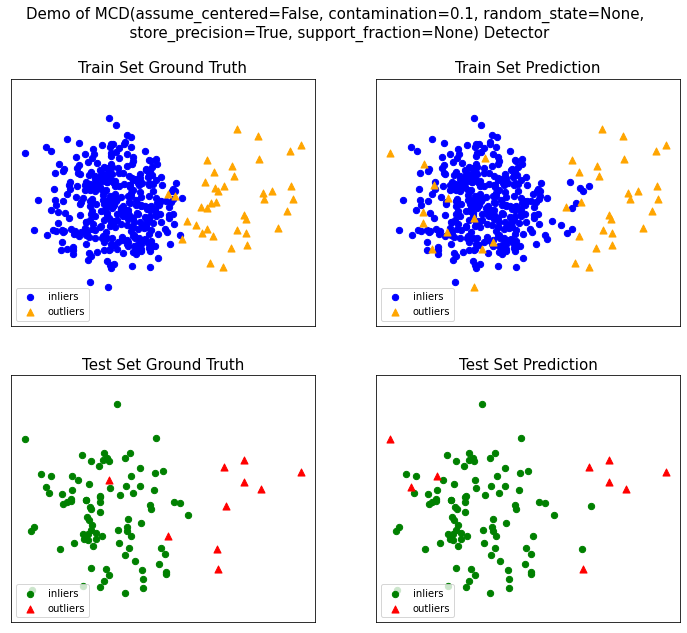

In [14]:
# (b)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Fit pca to X_train and X_test and transform 
train_principalComponents =pca.fit_transform(X_train) # YOUR CODE SHOULD COME HERE
test_principalComponents = pca.transform(X_test)# YOUR CODE SHOULD COME HERE

from pyod.utils.example import visualize
# Visualize the ground truth outliers and predicted outliers using visualize()

visualize(clf,X_train=train_principalComponents,y_train=y_train,
          X_test=test_principalComponents,y_test=y_test,
          y_train_pred=clf.predict(X_train),y_test_pred=clf.predict(X_test))

In [15]:
def print_evaluated_results(clf,chain=False):
  global X_train,X_test,y_train,y_test
  # print(y_train.shape)
  clf.fit(X_train)
  y_pred=clf.predict(X_test)
  y_score=clf.decision_function(X_test)

  
  if not chain:
    evaluate_print(clf,y_test,y_score)
    print('\n\n')
    return 
  return clf
  

def visualize_components(clf):
  global X_train,X_test,y_train,y_test

  pca = PCA(n_components=2)

  train_principalComponents= pca.fit_transform(X_train)
  test_principalComponents = pca.transform(X_test)


  clf=print_evaluated_results(clf,chain=True)
  visualize(clf,X_train=train_principalComponents,y_train=y_train,
            X_test=test_principalComponents,y_test=y_test,
            y_train_pred=clf.predict(X_train),y_test_pred=clf.predict(X_test))


# print_evaluated_results(clf)
# visualize_components(clf)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False) ROC:0.9278, precision @ rank n:0.7





D:\Anaconda_python\New folder\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda_python\New folder\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


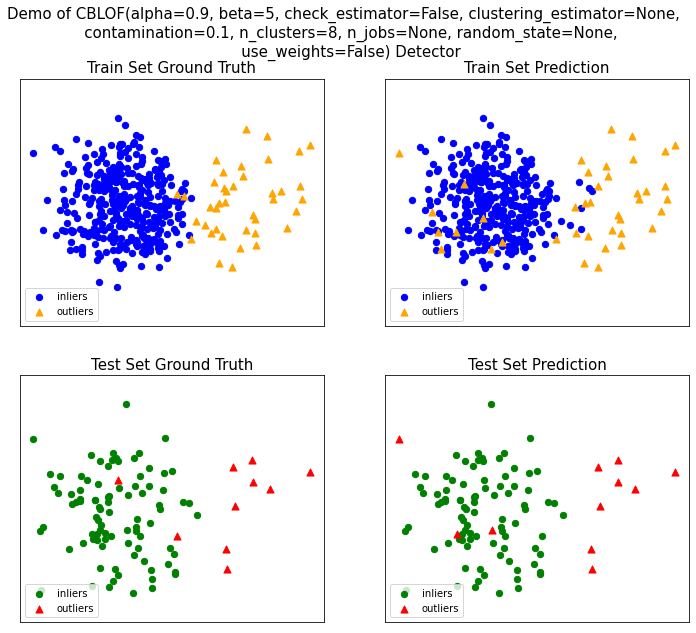

In [16]:
# (c)
from pyod.models.cblof import CBLOF
from pyod.models.copod import COPOD

# YOUR CODE SHOULD COME HERE

clf=CBLOF()
print_evaluated_results(clf)
visualize_components(clf)


COPOD(contamination=0.1, n_jobs=1) ROC:0.9556, precision @ rank n:0.8





D:\Anaconda_python\New folder\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Anaconda_python\New folder\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


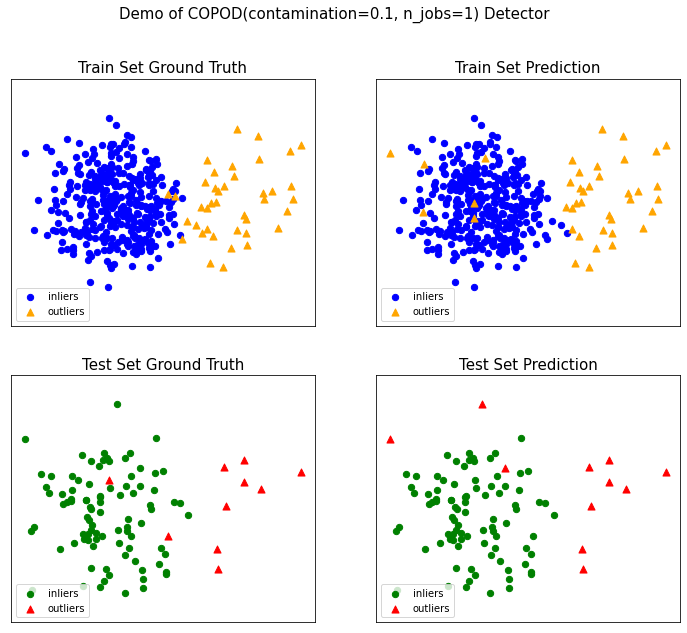

In [17]:
clf=COPOD()
print_evaluated_results(clf)
visualize_components(clf)

### Comparitive analysis

The ROC of the probablistic model is the highest. The precision score of COPOD, prob model is higher than that of both proximity based model and covariance dependent model.

The training of the MCD model was not proper and we can observe presence of predicted false outliers that has same associative behaviour as the data corpus in the MCD trained model.
The training has to some extent improved in probability based models.

There are presence of false positives in test set (detected as outlier class 1 but are not outliers), across every model. This can be attributed to behaviour of data points. 
Some green test based points are distant from the major corpus, top left, so a variation or any related discriminant function may assign them as outlier. 
Therefore they are hard to be estimated precisely.

In addition to this, while visualising the PCA graphs we can observe that variance based method was not able to detect the outliers that has similar variation distribution as other normal points.

It is evident that we should use a mix of approach while determining any sets of outliers.

# Question 4: PCA Conceptual questions (5 pts)
Explain the principle of Principal Component Analysis algorithm, especially why we can select the best projection bases based on the covariance matrix of data from the perspective of optimization?

# Answer:
Principal component analysis, PCA, is an unsupervised feature extraction technique, that tries to reduce the number of features of the dataset, by maintaing an optimal level of variability of the dataset.

PCA is a linear transformation, that is hypothesised around finding vector directions, in stepwise manner, where the varaiation of the data is best explained.

This transformation is thus carried out in form of optimization, where one tries to find transformation ratios for all the features, that project the instances in the direction where the variation is maximized.

Following, another vector direction is computed to explain the variation that the first vector component failed to realize. This variation is primarily the projection of instances on the vector orthogonal to the primary component vector.

This process of optimization and orthogonal variance computation is iteratively carried out till the entire dataset is explained using computed vectors.

Thus this process is equivalent to computing eigenvalues and eigenvectors of covariance matrix. The sum of eigenvalues of selected eigenvectors helps to determine the amount of varaiation of data explained. Whereas, the eigenvectors act as the respective PCA directions of the datset.  





# Question 5: Pre-processing and sampling (15 pts)

The following dataset contains House prices describing the sales of individual residential property in Ames, Iowa data with explanatory variables describing almost every aspect of residential homes and dependent variable being SalePrice. Here, some cells of most columns in the dataset contain NaN values.













In [18]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
np.random.seed(100)

data = pd.read_csv("sales_data.csv")
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice
0,60,RL,65.0,8450,NaN,7,5,2003,2003,196.0,...,0,0,0,NaN,NaN,NaN,0,2,2008,208500
1,20,RL,80.0,9600,NaN,6,8,1976,1976,0.0,...,0,0,0,NaN,NaN,NaN,0,5,2007,181500
2,60,RL,68.0,11250,NaN,7,5,2001,2002,162.0,...,0,0,0,NaN,NaN,NaN,0,9,2008,223500
3,70,RL,60.0,9550,NaN,7,5,1915,1970,0.0,...,0,0,0,NaN,NaN,NaN,0,2,2006,140000
4,60,RL,84.0,14260,NaN,8,5,2000,2000,350.0,...,0,0,0,NaN,NaN,NaN,0,12,2008,250000



a) **(2 pts)** Print the number of NaN values in each column.


In [19]:
data.isna().sum(axis=0)

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Alley            1369
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea          8
ExterQual           0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageCars          0
GarageArea          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
PoolQC           1453
Fence            1179
MiscFeatur

b) **(3 pts)** Create a copy of `data`, and name it `data_dm`, then create a new column in `data_dm` named `binned_yr_built` and apply binning to the column `yr_built`. Use `pandas.cut()` and modify its paramter list as below:

```
bins=[1900, 1920, 1940, 1960, 1980, 2000, 2020]
labels=['1900-1920', '1920-1940', '1940-1960', '1960-1980', '1980-2000', '2000-2020']
include_lowest=True
```
Next, perform one-hot encoding on this new column.

In [20]:
# data_dm.columns

In [21]:
data_dm=data.copy()

bins=[1900, 1920, 1940, 1960, 1980, 2000, 2020]
labels=['1900-1920', '1920-1940', '1940-1960', '1960-1980', '1980-2000', '2000-2020']

data_dm.loc[:,'binned_yr_built']=pd.cut(data_dm['YearBuilt'],bins=bins,labels=labels,include_lowest=True)

In [22]:
pd.get_dummies(data_dm['binned_yr_built'])

,1900-1920,1920-1940,1940-1960,1960-1980,1980-2000,2000-2020
0,0,0,0,0,0,1
1,0,0,0,1,0,0
2,0,0,0,0,0,1
3,1,0,0,0,0,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
1455,0,0,0,0,1,0
1456,0,0,0,1,0,0
1457,0,0,1,0,0,0
1458,0,0,1,0,0,0



c) **(2 pts)** Drop the columns which have more than 65 percentage of missing values.

In [23]:
msk=(data.notna().sum()/data.shape[0])<=0.65
cols_tbu=msk[msk==True].index


data.drop(cols_tbu,axis=1,inplace=True)



d) **(3 pts)** Take a sample of 800 rows at random and compute its mean, compare this value with the population mean.
  

Text(180421.19589041095, 0.01, 'Population mean')

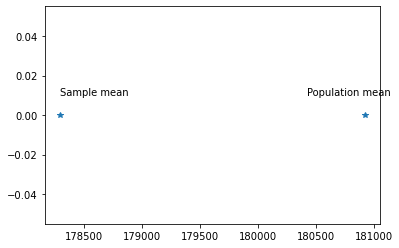

In [24]:
np.random.seed(6)
sample_ages = np.random.choice(a= data['SalePrice'], size=800)
#Sample mean
sam_mean=np.mean(sample_ages)
#Population mean
pop_mean=data['SalePrice'].mean()

import matplotlib.pyplot as plt

plt.plot([sam_mean,pop_mean],[0,0],'*')
plt.text(sam_mean,0.01,'Sample mean')
plt.text(pop_mean-500,0.01,'Population mean')

e) **(2pts)** Calculate the 95% confidence intervals for SalePrice with a sample size of 100. 

**(3pts)** Calculate the 95% confidence intervals for 100 different trials with a sample size of 500. Plot the confidence intervals and interpret how it captures the population mean.

<AxesSubplot:ylabel='Frequency'>

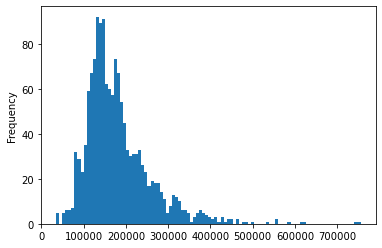

In [25]:
data['SalePrice'].plot(kind='hist',bins=100)#Seems to be a skewed distribution therefore z score for individual sample cannot be computed 
#Thus we will build confidence interval for sample statistics using central limit theorem

In [26]:
np.random.seed(10)
sample_size = 100
sample = np.random.choice(a= data_dm['SalePrice'],
                          size = sample_size)
sample_mean = sample.mean()
population_mean=data_dm['SalePrice'].mean()
population_sigma=pow(data_dm['SalePrice'].var(),1/2)


#The statistic of the sample space will be normally distributed about the population mean with a reduced standard deviation of sigma/sqrt(sample size)
#Statistic here is the mean

#Get the critical Z value
sample_std=population_sigma/(np.sqrt(sample_size))
Z=(sample_mean-population_mean)/(sample_std)
z_critical=1.96#For two tail normal distribution

#Get population standard deviation
population_sigma=pow(data_dm['SalePrice'].var(),1/2)
pop_stdev=pow(data_dm['SalePrice'].var(),1/2)


#margin of error
margin_of_error = z_critical * (pop_stdev/math.sqrt(sample_size)) 

#confidence interval
confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

#Print confidence interval and true mean value
print(confidence_interval)

(166521.7994349542, 197663.26056504578)


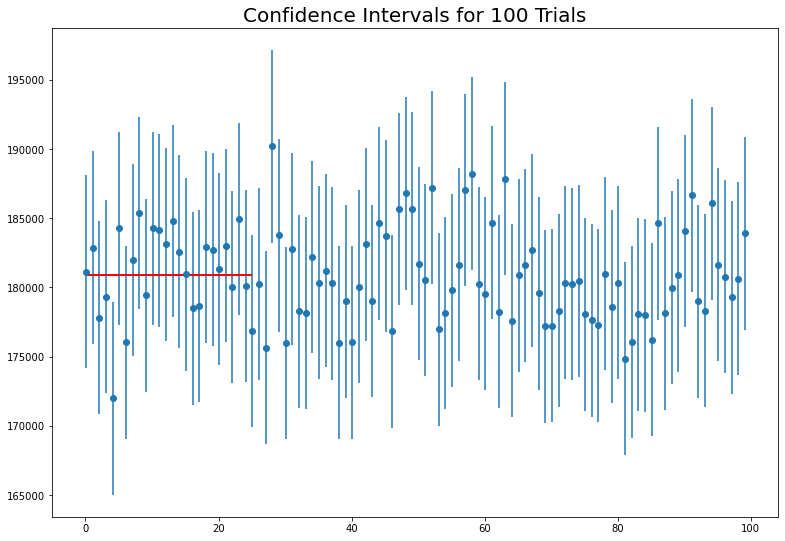

In [27]:
np.random.seed(12)

sample_size = 500

intervals = []
sample_means = []

for sample in range(100):
    sample = np.random.choice(a= data_dm['SalePrice'], size = sample_size)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)
    # compute z critical value
    z_critical=1.96

    # compute population standard deviation     
  
    margin_of_error = z_critical * (pop_stdev/math.sqrt(sample_size))
    confidence_interval = (sample_mean - margin_of_error,
                           sample_mean + margin_of_error)  
    
    intervals.append(confidence_interval)
    
plt.figure(figsize=(13, 9))

plt.errorbar(x=np.arange(0.1, 100, 1), 
             y=sample_means, 
             yerr=[(top-bot)/2 for top,bot in intervals],
             fmt='o')

plt.hlines(xmin=0, xmax=25,
           y=data['SalePrice'].mean(), 
           linewidth=2.0,
           color="red")
plt.title('Confidence Intervals for 100 Trials', fontsize = 20)
plt.show()